## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting the correct path

In [2]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'dropconnect'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/


## Imports

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


import numpy as np 
import tensorflow as tf 
from tensorflow.keras.models import load_model
import random
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input



import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

## Load data

In [4]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()
print(train_labels[20])
print(val_labels[30])
print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)
[0.1816508]
[0.25773296]
[0.12732958]


## Class definitions

### Define dropconnect class

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Dense, Conv2D, Wrapper
from tensorflow.keras.layers import ReLU, BatchNormalization, Flatten, MaxPool2D, Input


#classes

class DropConnectDense(Dense):
    def __init__(self, *args, **kwargs):
        self.prob = kwargs.pop('prob', 0.5)
        if not 0. <= self.prob < 1.:
            raise NameError('prob must be at range [0, 1)]')


        super(DropConnectDense, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.in_feature = input_shape[-2]
        
        super(DropConnectDense, self).build(input_shape)

    def call(self, inputs, train=True):
        if train:
            print('if train value ', train)
            mask = tf.cast(tf.random.uniform((self.in_feature, self.units)) <= self.prob, tf.float32)
            kernel = tf.multiply(self.kernel, mask)
            output = tf.matmul(inputs, kernel)
        else:
            print('else train value ', train)
            output = tf.matmul(inputs, self.kernel * (1 - self.prob))
          
        if self.use_bias:
            output += self.bias
        return self.activation(output)
        
    
class DropConnectConv2D(Conv2D):
    def __init__(self, *args, **kwargs):
        self.prob = kwargs.pop('prob', 0.5)
        if not 0. <= self.prob < 1.:
            raise NameError('prob must be at range [0, 1)]')

        super(DropConnectConv2D, self).__init__(*args, **kwargs)

        if type(self.padding) is str:
            self.padding = self.padding.upper()

        
    def build(self, input_shape):
        self.in_channel = input_shape[-1]
        
        super(DropConnectConv2D, self).build(input_shape)

    def call(self, inputs, train=False):
        if train:
            mask = tf.cast(tf.random.uniform((self.kernel_size[0], self.kernel_size[1], self.self.in_channel, self.filters)) <= self.prob, tf.float32)
            kernel = tf.multiply(self.kernel, mask)
            output = tf.nn.conv2d(inputs,
                                  kernel,
                                  strides=self.strides,
                                  padding=self.padding,
                                  dilations=self.dilation_rate)
        else:
            output = tf.nn.conv2d(inputs,
                                  self.kernel * (1 - self.prob),
                                  strides=self.strides,
                                  padding=self.padding,
                                  dilations=self.dilation_rate)
          
        if self.use_bias:
            output = tf.nn.bias_add(output, self.bias)
        return self.activation(output)



class DropConnect(Wrapper):
    def __init__(self, layer, prob=0.0, **kwargs):

        if not 0. <= prob < 1.:
            raise NameError('prob must be at range [0, 1)]')

        self.prob = prob
        self.layer = layer
  
        super(DropConnect, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True

        self.n_trainable = len(self.layer.trainable_weights)

        super(DropConnect, self).build()

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def call(self, x):
        for counter in range(self.n_trainable):
            self.layer.trainable_weights[counter] = K.in_train_phase(K.dropout(self.layer.trainable_weights[counter], self.prob),
                                                                     self.layer.trainable_weights[counter] * (1-self.prob))
        return self.layer.call(x)

## Define and train Dropconnect model

else train value  False
else train value  False
THIS IS THE TRAINING PHASE
Epoch 1/2
else train value  False
else train value  False
else train value  False
else train value  False
else train value  False
else train value  False
399/399 - 3s - loss: 0.0648 - mae: 0.1953 - val_loss: 0.0571 - val_mae: 0.1881 - 3s/epoch - 8ms/step
Epoch 2/2
399/399 - 2s - loss: 0.0547 - mae: 0.1844 - val_loss: 0.0555 - val_mae: 0.1871 - 2s/epoch - 5ms/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 drop_connect_dense (DropCon  (None, 128)              1152      
 nectDense)                                                      
                                                                 
 drop_connect_dense_1 (DropC  (None, 1)                129       
 onnectDense)   

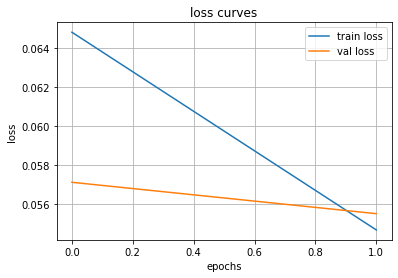

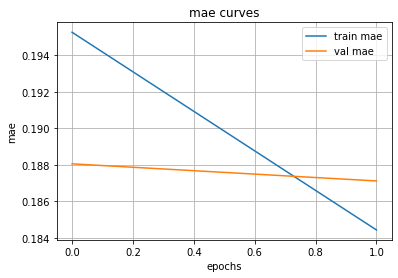

THIS IS THE INFERENCE PHASE
(3000, 8)
else train value  False
else train value  False
output 
 [[0.408594  ]
 [0.41360644]
 [0.4151237 ]
 ...
 [0.3840742 ]
 [0.41682076]
 [0.43081582]]
output shape  (3000, 1)
(3000, 8)
output 
 [[0.408594  ]
 [0.41360644]
 [0.4151237 ]
 ...
 [0.3840742 ]
 [0.41682076]
 [0.43081582]]
output shape  (3000, 1)


In [6]:
# DROPCONNECT MODEL
def train_dropconnect_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob, noise_shape, train_flag=None):
    #obtained from hyperparameter optimization
    K.clear_session()
    #model = Sequential()
    inp = Input(shape=(8, ))
    x = DropConnectDense(128, activation="relu", prob=0.5)(inp)
    #model.add(DropConnectDense(32, activation='relu', prob=prob, noise_shape=noise_shape, use_learning_phase=train_flag))

    out = DropConnectDense(1, activation="relu", prob=0.5)(x)

    model = Model(inputs=[inp], outputs=[out])

    model.compile(loss='mse', optimizer='sgd', metrics=['mae'])

    # train a model with dropconnect() layer
    print('THIS IS THE TRAINING PHASE')
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)
    #saving the model that has custom layers
    model.save(path+'dropconnect_model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5') 
    model.summary()

    # plotting the training and validation curves 
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.show()

    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('mae')
    plt.title('mae curves')
    plt.show()

    # call the stochasticregressor class and pass the trained model that contains the dropconnect layer 
    #mc_model = StochasticRegressor(model)
    print('THIS IS THE INFERENCE PHASE')

    #pred_samples, pred_mean, pred_std = model.predict_output(x_test, num_samples=num_samples)
    #print('pred_samples shape \n', pred_samples.shape)
    
    
    #print('pred_mean shape \n', pred_mean.shape)
    #print('pred_std shape \n', pred_std.shape)

    # return the predicted_samples, predicted_mean, predicted_std and model 
    #return pred_samples, pred_mean, pred_std, mc_model


    for i in range(num_samples):
        print(x_test.shape)
        output = model.predict(x_test)
        print('output \n', output)
        print('output shape ', output.shape)

epochs=2
num_samples=2
prob=0.2
noise_shape=None


train_dropconnect_model(train_data, train_labels, val_data, val_labels, test_data, epochs, num_samples, prob, noise_shape, train_flag=None)


In [7]:

'''
# running this command creates the stochastic dropconnect model, trains it and generates the predicted_samples, predicted_mean and predicted_std for the test set (all 3000 examples)
#prediction_samples, prediction_mean, prediction_std, dropconnect_model = train_dropconnect_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_samples=num_samples, prob=prob, noise_shape=noise_shape)
print('prediction mean :\n', prediction_mean)
print('prediction mean shape ', prediction_mean.shape)
print('prediction std :\n', prediction_std)
print('prediction std shape ', prediction_std.shape)
print('prediction samples :\n', prediction_samples)
print('prediction samples shape ', prediction_samples.shape)
print('unique standard deviation values \n', np.unique(prediction_std))
'''

"\n# running this command creates the stochastic dropconnect model, trains it and generates the predicted_samples, predicted_mean and predicted_std for the test set (all 3000 examples)\n#prediction_samples, prediction_mean, prediction_std, dropconnect_model = train_dropconnect_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_samples=num_samples, prob=prob, noise_shape=noise_shape)\nprint('prediction mean :\n', prediction_mean)\nprint('prediction mean shape ', prediction_mean.shape)\nprint('prediction std :\n', prediction_std)\nprint('prediction std shape ', prediction_std.shape)\nprint('prediction samples :\n', prediction_samples)\nprint('prediction samples shape ', prediction_samples.shape)\nprint('unique standard deviation values \n', np.unique(prediction_std))\n"